1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍 (O)
2. 이상치 처리 
    - lof, iso 유지 (O)
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [11]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.0075, # 0.0075

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=False,
    downsampled_pass_rate=1.0,
    upsampled_total_fail_rate=0.40
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[process Log] Loading Raw Data...
[process Log] Done

[process Log] Processing Nan Value...
[process Log] Done

[process Log] Encoding Categorical Features...
[process Log] Done

[process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (92014, 23)
[Outlier-Remover Log] Without Outliers Shape : (91323, 23)
[process Log] Done

[process Log] T-Testing...
[process Log] Done

[process Log] Data Scaling (MinMaxScaler)...
[process Log] Done

[process Log] Train Test Spliting...
[process Log] Done

[process Log] Data Resampling...
[process Log] Done

train : [1 0]
test : [1 0]
======================= [Done] =======================


# Modeling

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [13]:
def modelTest(model):
    fold_f1_score = []
    n_iter = 0
    idx_list = []

    for train_idx, val_idx in strat_folder.split(x_train, y_train):
        train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
        train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(train_data, train_label)

        val_pred = model.predict(val_data)
        val_f1_score = f1_score(val_label, val_pred)
        val_report = classification_report(val_label, val_pred)

        n_iter += 1
        fold_f1_score.append([n_iter, val_f1_score])
        idx_list.append([train_idx, val_idx])

        print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

    fold_f1_score.sort(key=lambda x : x[1], reverse=True)
    print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

    best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
    best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]
    model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

    plt.figure(figsize=(15,5))

    # validation
    plt.subplot(1,2,1)
    pred = model.predict(x_train.iloc[best_fold_val_idx])
    cm = confusion_matrix(y_train[best_fold_val_idx], pred)
    sns.heatmap(cm, annot=True, fmt='.0f')

    # test
    plt.subplot(1,2,2)
    pred = model.predict(x_test)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='.0f')
    plt.show()

    print(classification_report(y_test, pred))
    print(f'test f1_score : {f1_score(y_test, pred)}')

# LGBM

[LightGBM] [Info] Number of positive: 22527, number of negative: 56318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 78845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285712 -> initscore=-0.916300
[LightGBM] [Info] Start training from score -0.916300
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      0.99      0.99     19712
weighted avg       1.00      1.00      1.00     19712

[LightGBM] [Info] Number of positive: 22527, number of negative: 56318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

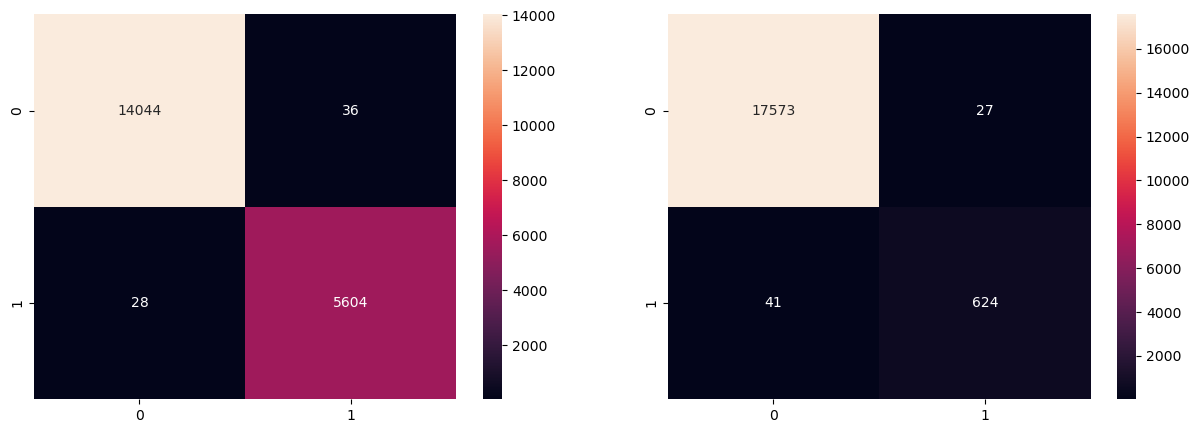

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17600
         1.0       0.96      0.94      0.95       665

    accuracy                           1.00     18265
   macro avg       0.98      0.97      0.97     18265
weighted avg       1.00      1.00      1.00     18265

test f1_score : 0.9483282674772037


In [14]:
model = LGBMClassifier(random_state=42)
modelTest(model)

# XGBoost

StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      1.00      1.00     19712
weighted avg       1.00      1.00      1.00     19712

StratifiedShuffleSplit 2 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      0.99      0.99      5632

    accuracy                           1.00     19712
   macro avg       1.00      1.00      1.00     19712
weighted avg       1.00      1.00      1.00     19712

StratifiedShuffleSplit 3 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14080
         1.0       0.99      1.00      0.99      5632

    accuracy                           1.00     19712

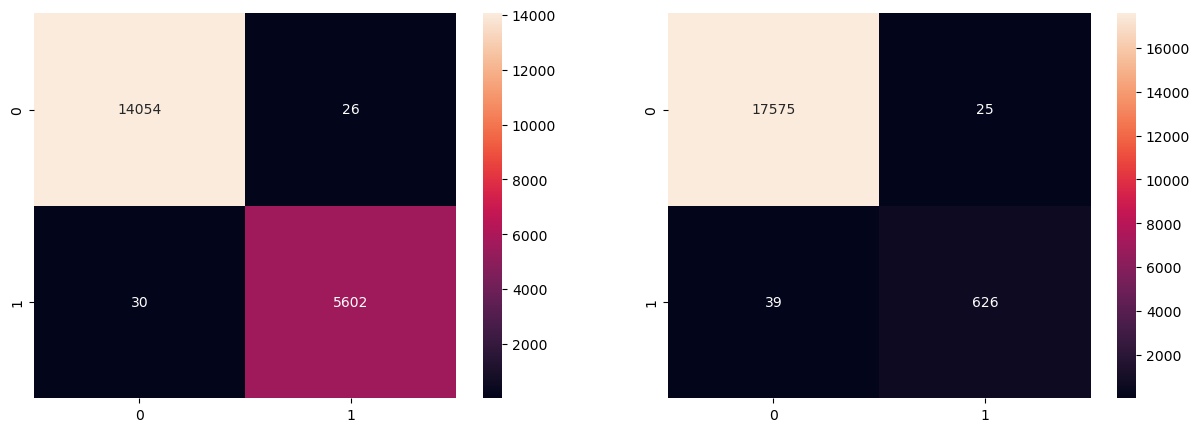

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17600
         1.0       0.96      0.94      0.95       665

    accuracy                           1.00     18265
   macro avg       0.98      0.97      0.97     18265
weighted avg       1.00      1.00      1.00     18265

test f1_score : 0.9513677811550152


In [15]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)
modelTest(model)

# Conv1D

In [ ]:
# !pip install tensorflow

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류의 경우 sigmoid 사용
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# x_train과 x_test의 차원을 CNN에 맞게 변환 (예: (samples, timesteps, features))
x_train_cnn = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

In [19]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def modelTest_CNN():
    fold_f1_score = []
    n_iter = 0
    idx_list = []

    input_shape = (x_train_cnn.shape[1], x_train_cnn.shape[2])  # CNN 모델 입력 크기 정의

    for train_idx, val_idx in strat_folder.split(x_train_cnn, y_train):
        train_data, val_data = x_train_cnn[train_idx], x_train_cnn[val_idx]
        train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # CNN 모델 생성 및 학습
        model = create_cnn_model(input_shape)
        model.fit(train_data, train_label, epochs=10, batch_size=32, verbose=0)

        val_pred = (model.predict(val_data) > 0.5).astype("int32")  # 이진 분류일 때 예측값을 이진으로 변환
        val_f1_score = f1_score(val_label, val_pred)
        val_report = classification_report(val_label, val_pred)

        n_iter += 1
        fold_f1_score.append([n_iter, val_f1_score])
        idx_list.append([train_idx, val_idx])

        print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

    fold_f1_score.sort(key=lambda x : x[1], reverse=True)
    print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

    best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
    best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

    # 최적의 fold에서 다시 학습 (train set 전체로 학습)
    model.fit(x_train_cnn[best_fold_train_idx], y_train.iloc[best_fold_train_idx], epochs=10)

    plt.figure(figsize=(15,5))

    # validation confusion matrix
    plt.subplot(1,2,1)
    pred_val = (model.predict(x_train_cnn[best_fold_val_idx]) > 0.5).astype("int32")
    cm_val = confusion_matrix(y_train.iloc[best_fold_val_idx], pred_val)
    sns.heatmap(cm_val, annot=True, fmt='.0f')

    # test confusion matrix
    plt.subplot(1,2,2)
    pred_test = (model.predict(x_test_cnn) > 0.5).astype("int32")
    cm_test = confusion_matrix(y_test, pred_test)
    sns.heatmap(cm_test, annot=True, fmt='.0f')
    plt.show()

    print(classification_report(y_test, pred_test))
    print(f'test f1_score : {f1_score(y_test, pred_test)}')

c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     14080
         1.0       0.97      0.88      0.92      5632

    accuracy                           0.96     19712
   macro avg       0.96      0.94      0.95     19712
weighted avg       0.96      0.96      0.96     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 2 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     14080
         1.0       0.96      0.89      0.93      5632

    accuracy                           0.96     19712
   macro avg       0.96      0.94      0.95     19712
weighted avg       0.96      0.96      0.96     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 3 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     14080
         1.0       0.99      0.88      0.93      5632

    accuracy                           0.96     19712
   macro avg       0.97      0.94      0.95     19712
weighted avg       0.96      0.96      0.96     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 4 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     14080
         1.0       0.98      0.84      0.90      5632

    accuracy                           0.95     19712
   macro avg       0.96      0.91      0.93     19712
weighted avg       0.95      0.95      0.95     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 5 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     14080
         1.0       0.95      0.91      0.93      5632

    accuracy                           0.96     19712
   macro avg       0.96      0.95      0.95     19712
weighted avg       0.96      0.96      0.96     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
StratifiedShuffleSplit 6 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     14080
         1.0       0.97      0.88      0.92      5632

    accuracy                           0.96     19712
   macro avg       0.96      0.93      0.95     19712
weighted avg       0.96      0.96      0.96     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 7 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     14080
         1.0       0.93      0.91      0.92      5632

    accuracy                           0.95     19712
   macro avg       0.95      0.94      0.94     19712
weighted avg       0.95      0.95      0.95     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 8 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     14080
         1.0       0.95      0.90      0.92      5632

    accuracy                           0.96     19712
   macro avg       0.95      0.94      0.95     19712
weighted avg       0.96      0.96      0.96     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 9 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     14080
         1.0       0.93      0.89      0.91      5632

    accuracy                           0.95     19712
   macro avg       0.94      0.93      0.94     19712
weighted avg       0.95      0.95      0.95     19712



c:\Users\greatsangho\AppData\Local\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
StratifiedShuffleSplit 10 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     14080
         1.0       0.98      0.86      0.91      5632

    accuracy                           0.95     19712
   macro avg       0.96      0.92      0.94     19712
weighted avg       0.96      0.95      0.95     19712

   Fold        F1
0     5  0.928281
1     3  0.927907
2     2  0.925731
3     6  0.923320
4     1  0.922905
5     8  0.921533
6     7  0.917791
7    10  0.914042
8     9  0.907951
9     4  0.901675
Epoch 1/10
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9528 - loss: 0.1520
Epoch 2/10
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9547 - loss: 0.1495
Epoch 3/10
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9558 - loss: 0.1444
Epoch 4/10
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9577 - loss: 0.1404
Epoch 5/10
2464/2464 ━━━━━━━━━━━━━━━━━

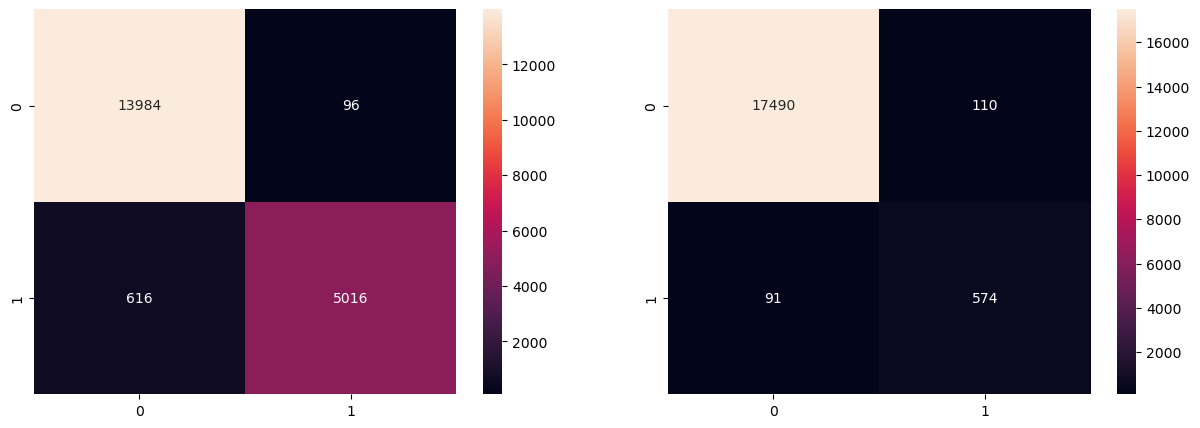

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     17600
         1.0       0.84      0.86      0.85       665

    accuracy                           0.99     18265
   macro avg       0.92      0.93      0.92     18265
weighted avg       0.99      0.99      0.99     18265

test f1_score : 0.8510007412898444


In [20]:
modelTest_CNN()

# 트랜스포머

In [21]:
!pip install transformers
# pip install torch